In [4]:
# Import libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# Import datasets

sep_data = th.load('../datasets/sep_states.pt')

ent_data = th.load('../datasets/ent_states.pt')

# sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim=2)
# ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim=1)

# sep_data_pair.shape, ent_data_pair.shape

In [49]:
sep_train, sep_test = train_test_split(sep_data, test_size=0.3)
ent_train, ent_test = train_test_split(ent_data, test_size=0.3)

sep_train.shape, sep_test.shape, ent_train.shape, ent_test.shape

(torch.Size([7000, 4]),
 torch.Size([3000, 4]),
 torch.Size([7000, 4]),
 torch.Size([3000, 4]))

In [60]:
sep_train_pair = th.stack((sep_train.real, sep_train.imag), dim=1)
ent_train_pair = th.stack((ent_train.real, ent_train.imag), dim=1)

sep_test_pair = th.stack((sep_test.real, sep_test.imag), dim=1)
ent_test_pair = th.stack((ent_test.real, ent_test.imag), dim=1)

sep_train_pair.shape, ent_train_pair.shape

(torch.Size([7000, 2, 4]), torch.Size([7000, 2, 4]))

In [61]:
# # Split the data into training and testing sets

# sep_train, sep_test = train_test_split(sep_data_pair, test_size=0.3)
# ent_train, ent_test = train_test_split(ent_data_pair, test_size=0.3)

# sep_train.shape, sep_test.shape, ent_train.shape, ent_test.shape

In [64]:
BATCH_SIZE = 64
ent_train_loader = DataLoader(ent_train_pair, batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(ent_test_pair, batch_size=BATCH_SIZE, shuffle=True)
sep_train_loader = DataLoader(sep_train_pair, batch_size=BATCH_SIZE, shuffle=True)
sep_test_loader = DataLoader(sep_test_pair, batch_size=BATCH_SIZE, shuffle=True)

ent_train_loader.dataset.shape, ent_train_loader.dataset.shape

(torch.Size([7000, 2, 4]), torch.Size([7000, 2, 4]))

In [76]:
class VAE_fc(nn.Module):
    def __init__(self, input_size, in_channels, hidden_size, kernel_size):
        super(VAE_fc, self).__init__()
        
        data_size = input_size
        self.enc1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_size[0], kernel_size = kernel_size[0])
        data_size = data_size - kernel_size[0] + 1
        
        self.enc2 = nn.Conv2d(in_channels=hidden_size[0], out_channels=hidden_size[1], kernel_size = kernel_size[1])
        data_size = data_size - kernel_size[1] + 1
        
        self.enc_mu = nn.Linear(hidden_size[1], hidden_size[2])
        self.enc_logvar = nn.Linear(hidden_size[1] * data_size, hidden_size[2])
        
        self.dec1 = nn.Linear(hidden_size[2], hidden_size[1])
        self.dec2 = nn.Linear(hidden_size[1], hidden_size[0])
        self.dec3 = nn.Linear(hidden_size[0], 2)
    
    def encoder(self, x):
        print("input", x.shape)
        x = F.relu(self.enc1(x))
        print("enc1", x.shape)
        x = F.relu(self.enc2(x))
        print("enc2", x.shape)
        x = x.view(x.shape[0], -1)
        print("view", x.shape)
        mu = F.relu(self.enc_mu(x))
        print("mu", mu.shape)
        logvar = F.relu(self.enc_logvar(x))
        
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = th.exp(0.5 * logvar)
        eps = th.randn_like(std)
        return mu + eps * std 
        
    
    def decoder(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        z = th.sigmoid(self.dec3(z))
        return z
    
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        # z = self.reparametrize(mu, logvar)
        # decoded = self.decoder(z)
        return  mu, logvar
    
model = VAE_fc(input_size=4, in_channels = 1, hidden_size=[10, 5, 2], kernel_size=[1, 1])

for _, data in enumerate(ent_train_loader):
    print(model(data.reshape(-1, 1, 2, 4)))
    break

input torch.Size([64, 1, 2, 4])
enc1 torch.Size([64, 10, 2, 4])
enc2 torch.Size([64, 5, 2, 4])
view torch.Size([64, 40])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x40 and 5x2)

In [ ]:
# Define the training function
def train_model(model, train_loader, epochs, optimizer, criterion, device):
    trained_model = model.to(device)
    trained_model.train()
    train_loss = []
    for epoch in range(epochs):
        batch_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            decoded, z, mu, logvar = trained_model(data)
            loss = criterion(data.flatten(start_dim=1), decoded, mu, logvar)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        train_loss.append(batch_loss)
        
        print(f'Epoch: {epoch + 1}, Loss: {batch_loss:.4f}')
    return trained_model, np.array(train_loss)

def get_test_loss(trained_model, test_loader, criterion):
    trained_model.eval()
    decoded_data = []
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        decoded, z, mu, logvar = trained_model(data.flatten(start_dim=1))
        decoded_data.append(decoded.detach().numpy())
        test_loss += criterion(data.flatten(start_dim=1), decoded, mu, logvar).item()
    return test_loss, np.array(decoded_data)

In [ ]:
def VAE_loss(input, output, mu, logvar):
    reconstruction_loss = F.mse_loss(output, input, reduction='sum')
    KL_loss = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + 0.5 * KL_loss

In [ ]:
model = VAE_fc(input_size=81 * 2, hidden_size=[81, 40, 20])
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

trained_model_ent, train_loss_ent = train_model(model, ent_train_loader, 10, optimizer, VAE_loss, 'cpu')

Epoch: 1, Loss: 67621.8928
Epoch: 2, Loss: 287.3284
Epoch: 3, Loss: 155.9150
Epoch: 4, Loss: 144.9152
Epoch: 5, Loss: 137.5894
Epoch: 6, Loss: 133.1552
Epoch: 7, Loss: 129.5133
Epoch: 8, Loss: 127.4527
Epoch: 9, Loss: 126.9820
Epoch: 10, Loss: 125.5534


In [ ]:
model = VAE_fc(input_size=81 * 2, hidden_size=[81, 40, 20])
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

trained_model_sep, train_loss_sep = train_model(model, sep_train_loader, 10, optimizer, VAE_loss, 'cpu')

Epoch: 1, Loss: 70224.2004
Epoch: 2, Loss: 109.7213
Epoch: 3, Loss: 53.6267
Epoch: 4, Loss: 42.0341
Epoch: 5, Loss: 38.7095
Epoch: 6, Loss: 36.0985
Epoch: 7, Loss: 35.1431
Epoch: 8, Loss: 34.1364
Epoch: 9, Loss: 33.3632
Epoch: 10, Loss: 32.4152


In [ ]:
test_loss_ent = []
test_loss, decoded_ent = get_test_loss(trained_model_ent, ent_test_loader, VAE_loss)
test_loss_ent.append(test_loss)
test_loss, decoded_ent = get_test_loss(trained_model_ent, sep_test_loader, VAE_loss)
test_loss_ent.append(test_loss)

test_loss_sep = []
test_loss, decoded_sep = get_test_loss(trained_model_sep, ent_test_loader, VAE_loss)
test_loss_sep.append(test_loss)
test_loss, decoded_sep = get_test_loss(trained_model_sep, sep_test_loader, VAE_loss)
test_loss_sep.append(test_loss)

test_loss_ent, test_loss_sep

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_53866/4184396661.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


([53.97199733555317, 25.14327786117792],
 [65.45677861571312, 13.75332409888506])

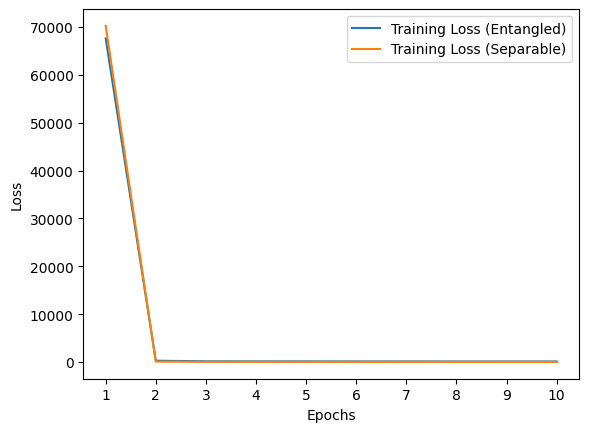

In [ ]:
x_values = np.arange(1, len(train_loss_ent) + 1)
plt.plot(x_values, train_loss_ent, label='Training Loss (Entangled)')
plt.plot(x_values, train_loss_sep, label='Training Loss (Separable)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(x_values)
plt.legend()